In [52]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt # Helps plot
import numpy as np # Numerical operations

import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.colors as colors

#import fiona # Needed for geopandas to run
import geopandas as gpd # this is the main geopandas 
#from shapely.geometry import Point, Polygon # also needed


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
os.getcwd() + "\\zillow\\zillow_med_price"


'C:\\GitHub\\data_bootcamp_spring_2019\\mapping\\zillow\\zillow_med_price'

In [3]:
df = pd.read_csv(os.getcwd() + "\\zillow\\zillow_med_price.csv",encoding = "ISO-8859-1")

In [5]:
new_path = os.getcwd() + "\\zillow\\zillow_med_price.parquet"

pq.write_table(pa.Table.from_pandas(df), new_path)

In [6]:
df = df.melt(id_vars = ["RegionID","RegionName","City","State","Metro","CountyName","SizeRank"
])

In [81]:
nyc_price = df[(df.City == "New York") & (df.variable == "2018-06")].copy()

In [82]:
nyc_price.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,variable,value
3934406,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,2018-06,1344.0
3934408,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,2018-06,1648.0
3934414,61616,10002,New York,NY,New York-Newark-Jersey City,New York County,9,2018-06,1434.0
3934415,61807,10467,New York,NY,New York-Newark-Jersey City,Bronx County,10,2018-06,262.0
3934416,62037,11226,New York,NY,New York-Newark-Jersey City,Kings County,11,2018-06,576.0


In [83]:
nyc_price["ZIPCODE"] = nyc_price.RegionName.astype(int)

new_name_dict = {"value": "price"}

nyc_price.rename(columns= new_name_dict, inplace=True)

nyc_price["log_price"] = np.log(nyc_price.price)

In [84]:
cwd = os.getcwd()

regions_shape = cwd + "\\shapefile\\ZIP_CODE_040114.shx"

regions_shape

nyc_map = gpd.read_file(regions_shape)

nyc_map.ZIPCODE = nyc_map.ZIPCODE.astype(int) # we want these to look like numbers


In [85]:
nyc_map  = nyc_map.merge(nyc_price, on='ZIPCODE', how = "left", indicator = True)

In [86]:
nyc_map.price.replace(np.nan,0.0, inplace = True)

In [87]:
nyc_map.tail()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,RegionName,City,State,Metro,CountyName,SizeRank,variable,price,log_price,_merge
258,10310,0,Staten Island,25003.0,5.346328e+07,NY,Richmond,36,085,http://www.usps.com/,...,10310.0,New York,NY,New York-Newark-Jersey City,Richmond County,5729.0,2018-06,346.0,5.846439,both
259,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,Kings,36,047,http://www.usps.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,left_only
260,11249,0,Brooklyn,28481.0,1.777221e+07,NY,Kings,36,047,http://www.usps.com/,...,11249.0,New York,NY,New York-Newark-Jersey City,Kings County,1717.0,2018-06,1232.0,7.116394,both
261,10162,1,New York,0.0,2.103489e+04,NY,New York,36,061,http://www.usps.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,left_only
262,10119,1,New York,0.0,1.263930e+05,NY,New York,36,061,http://www.usps.com/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,left_only


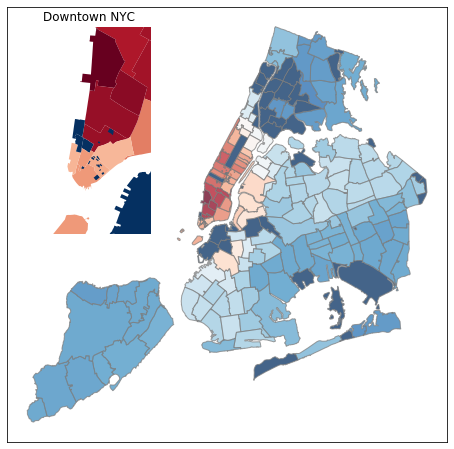

In [89]:
fig, ax = plt.subplots(figsize = (10,8))

# First create the map for the urban share

nyc_map.plot(ax = ax, edgecolor='tab:grey',
             column='price', # THIS IS NEW, it says color it based on this column
             cmap='RdBu_r', # This is the color map scheme https://matplotlib.org
             #/examples/color/colormaps_reference.html
             alpha = 0.75,
             vmin=0, vmax=nyc_price.price.max())

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#pcm = ax.pcolormesh(x, y, Z, vmin=-1., vmax=1., cmap='RdBu_r')

axins = zoomed_inset_axes(ax, # The original ax
                          4, # zoom level
                          loc=2, # location
                          borderpad=2)  # space around it relative to figure

nyc_map.plot(ax = axins, column='price', cmap='RdBu_r',
             vmin=0, vmax=nyc_price.price.max())

# Then create the map in the "insice ax" or axins. Note, that you do not
# need to keep the colering or the income, you could have the inset 
# be population or what ever else.

# then the stuff below picks the box for the inset to cover. I
# I kind of just eyballed this untill I zoomed into what I wanted

# Note the "axins" object really just works like the ax

x1, x2, y1, y2 = 975000, 987000, 190000, 210000
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.set_title("Downtown NYC")
# Make a title.

mark_inset(ax, axins, loc1=3, loc2=1, fc="none", alpha = 0.5)
# This then creates the lines that marks where the inset comes from

# Make it look nice
axins.spines["right"].set_visible(False)
axins.spines["top"].set_visible(False)
axins.spines["left"].set_visible(False)
axins.spines["bottom"].set_visible(False)

#axins.Tick.remove()

axins.get_xaxis().set_visible(False)
axins.get_yaxis().set_visible(False)


plt.show()